# Solving MaxCut with QAOA improved by zero-noise extrapolation

In this notebook we solve a simple _MaxCut_ problem with the _Quantum Approximate Optimization Algorithm_ (QAOA) [[Farhi, Goldstone, Gutmann, arXiv:1411.4028]](https://arxiv.org/abs/1411.4028) executed on a simulated noisy backend. 
In particular we are interested in investigating how _Mitiq_ can help reduce errors and improve the results.

## The MaxCut problem

A **graph**, is a mathematical object characterized by a set $V$ of **vertices (or nodes)** that we can number with integers $V=\{0, 1, 2, \dots, n-1\}$ and a set $E$ of **edges** (pairs of nodes) which can be defined as $E=\{(a_1, b_1), (a_2, b_2), ...., (a_m, b_m)\}$, where $a_j\neq b_j$ and  $a_j, b_j \in V$.


**Note:** If we are not interested in isolated nodes (not connected to any edge), the set of edges $E$ completely determine the graph $G=(V, E)$.

Therefore, in Python, we can represent a graph without isolated nodes as a list **list of tuples**, where each tuple is a **pair of integers**.
For example a **square graph** can be expressed as:

In [1]:
# Square graph
square_graph = [(0, 1), (1, 2), (2, 3), (3, 0)]

Given a graph $(V, E)$, the **MaxCut problem** is to divide the nodes $V$ into two disjoint subsets $V_A$ and $V_B$, such that the number of cuts (edges with one vertex in $V_A$ and one vertex in $V_B$) is maximized.

In [2]:
from typing import List, Tuple

def count_cuts(graph: List[Tuple[int]], set_a: set, set_b: set):
    """Counts the number of cuts of a graph bipartition."""
    num_cuts = 0
    for edge in graph:
        if edge[0] in set_a and edge[1] in set_b:
            num_cuts += 1
        if edge[0] in set_b and edge[1] in set_a:
            num_cuts += 1
    return num_cuts       

For example, for the square graph previously defined, the maximum number of cuts is $4$ which can be achieved by multiple solutions. For example one of the two optimal solutions is:

In [3]:
set_a = {0, 2}
set_b = {1, 3}

Indeed, in this case, we have a cut for all the edges of `square_graph`, and so their number is maximum. 

In [4]:
count_cuts(square_graph, set_a, set_b)

4

An example of a sub-optimal solution is instead:

In [5]:
set_a = {0}
set_b = {1, 2, 3}
count_cuts(square_graph, set_a, set_b)

2

### Representing a solution as bitstring

A handy way of representing a candidate solution of the MaxCut problem, is to use a bitstring $s_n \cdots s_2s_1$ in which each bit $s_j$ is associated to the $j_{\rm th}$ node of the graph. The value of each bit, $0$ or $1$, can be used to represent the corresponding subset, $V_A$ or $V_B$, to which the node belongs.

For example, using a big-endian convention, the previous optimal and sub-optimal solutions can be represented as:

In [6]:
optimal_string = "1010"
sub_optimal_string = "1110"

The corresponding function to count the number of graph cuts can be written in the following way wich is very similar to the quantum cost function that we will define in the next section.

In [7]:
def count_cuts_from_string(graph: List[Tuple[int]], bitstring: str):
    """Counts the number of cuts of a graph bipartition represented as a (big-endian) bitstring. 
    """
    cost = 0
    for i, j in graph:
        z1 = (2 * int(bitstring[-i]) - 1)
        z2 = (2 * int(bitstring[-j]) - 1)
        cost += -(1 - z1 * z2) // 2
    return -cost

Let's test this function:

In [8]:
# Test the function
count_cuts_from_string(square_graph, optimal_string)

4

In [9]:
count_cuts_from_string(square_graph, sub_optimal_string)

2

The MaxCut problem is **NP-hard**. This means that it is computationally very hard (at least as hard as any NP problem). It is widely suspected that NP-hard problems will never admit a polynomial algorithm even if we had at disposal an ideal quantum computer.

However, for practical applications, it is often possible to obtain good **approximations** of the optimal exact solution. In this notebook we are interested in using the _Quantum Approximate Optimization Algorithm_ (QAOA) to get an approximate solution the MaxCut problem for a given graph.

## Embedding a MaxCut problem into a physical Hamiltonian

Given a graph $G=(V,E)$ with $n=|V|$ nodes and $m=|E|$ edges, one can define the following Hamiltonian acting on a system of $n$ qubits:

$$H = \sum_{(i,\, j) \in E}  \frac{1}{2} (1 - Z_i Z_j),$$

where $Z_k$ is the Pauli-Z operator applied to the qubit $k$, such that $Z_k |0>_k = +|0 \rangle_k$ and $Z_k |1>_k = - |1 \rangle_k$.

Now we can associate each qubit of the system to a vertex of the graph. A potential solution of the MaxCut problem  (i.e., the partition $(V_A, V_B)$) can be represented by a quantum product state: 

$$|\psi \rangle = |s_n \rangle \cdots |s_2 \rangle |s_1\rangle, $$
where $s_j=0$ if $j \in V_A$, while $s_j=1$ if $j \in V_B$. 

In this case it is easy to check that the corresponding number of cuts is given by the opposite of the expectation value of the Hamiltonian $H$:

$$ \text{number of cuts } =  - \langle \psi | H | \psi \rangle .$$

In this physical picture, the MaxCut problem corresponds to the problem of finding the ground state of $H$ and the maximum number of cuts is equal to minus the ground state energy.

### Define the QAOA cost Hamiltonian using Cirq

In [10]:
from cirq import NamedQubit, Circuit, identity_each, ZZ
import numpy as np

def qaoa_hamiltonian(graph: List[Tuple[float]]) -> np.ndarray:
    """Returns the cost Hamiltonian assocated to the input graph.
    """
    # Get all the nodes of the graph
    nodes = list({node for edge in graph for node in edge})
    # Initialize the qubits. One for each node.
    qreg = [NamedQubit(str(nn)) for nn in nodes]
    # Define the Hamiltonian as a NumPy array
    np_identity = np.eye(2 ** len(nodes))
    zz_terms = np.real([Circuit([identity_each(*qreg), ZZ(qreg[i], qreg[j])]).unitary() for i, j in graph])
    local_terms = [-0.5 * (np_identity - zz_term) for zz_term in zz_terms]
    return sum(local_terms)
    

Since it is diagonal in the computational basis, we can get the ground state energy as follows:

In [11]:
eig_vals = np.diag(qaoa_hamiltonian(square_graph))
# Ground state energy
min(eig_vals)

-4.0

which, as expected, corresponds to the opposite of the maximum number of cuts of the original graph.

The associated optimal eigenstates are:


In [12]:
nodes = list({node for edge in square_graph for node in edge})
num_nodes = len(nodes)
optimal_bitstrings = [f"{j:b}".zfill(num_nodes) for j, eig_val in enumerate(eig_vals) if eig_val == min(eig_vals)]
optimal_bitstrings

['0101', '1010']

Which indeed correspond to the 2 optimal bipartitions of the original MaxCut problem:

In [13]:
[count_cuts_from_string(square_graph, bitstring) for bitstring in optimal_bitstrings]

[4, 4]

## Using the Quantum Approximate Optimization Algorithm to find the ground state

The size of the previously introduced Hamiltonian is $2^n \times 2^n$. So, when the graph has many nodes, finding  the eigenvalues and or the eigenstates as we did above becomes exponentially hard.

**Is there a way of finding the ground state of a Hamiltonian using a NISQ quantum computer?**

Here comes into play the so called  Quantum Approximate Optimization Algorithm (QAOA) [[Farhi, Goldstone, Gutmann, arXiv:1411.4028]](https://arxiv.org/abs/1411.4028).
This method consists of generating a potential solution state through a variational circuit $U_{\vec \alpha, \vec \beta}$ which depends on two vectors of $p$ real parameters $\vec \alpha = (\alpha_1, .... \alpha_p)$, $\vec \beta= (\beta_1, .... \beta_p)$ and has the following structure:
 
$$|\psi(\vec \alpha, \vec \beta) \rangle = U_{\vec \alpha, \vec \beta}|+\rangle ^{\otimes n} 
= R_{\alpha_p} W_{\beta_p} \cdots R_{\alpha_1} W_{\beta_1} |+\rangle ^{\otimes n},$$

where $|+> = (|0\rangle + |1\rangle)/\sqrt{2}$ and

$$W_{\beta} = e^{i \beta H }, \quad R_{\alpha} = e^{i \alpha \sum_{j=1}^n X_j },$$
corresponding to the time evolution generated by system Hamiltonian $H$ and by a mixing Hamiltonian $H_{\rm mix}= \sum_j X_j$, respectively.

After applying the circuit to generate $|\psi(\vec \alpha, \vec \beta) \rangle$, one can easily measure the energy of the final state

$$E(\vec \alpha, \vec \beta) =  \langle \psi(\vec \alpha, \vec \beta) | H |\psi(\vec \alpha, \vec \beta)\rangle,$$

via simple measurements in the computational basis of the qubits. Repeating this procedures for many steps and minimizing the **cost function** $E(\vec \alpha, \vec \beta)$ with respect to the parameters $\vec \alpha$ and $\vec \beta$ one can approximate the ground state of $H$.

The maximum number of cuts for the original graph will be given by the opposite of the optimal cost: $- E(\vec \alpha, \vec \beta)^*$.

The corresponding state will be a superposition of one or more optimal solution states $|s_1 \rangle |s_2 \rangle \cdots |s_n\rangle$ representing optimal bipartitions $(V_A, V_B)$ of the MaxCut problem.

### Defining the QAOA ansatz

In [14]:
from cirq import H, X
from typing import List, Tuple
    
def qaoa_ansatz(graph: List[Tuple[float]], params: List[float]) -> Circuit:

    # Get the list of unique nodes from the list of edges
    nodes = list({node for edge in graph for node in edge})

    # Initialize the qubits
    qreg = [NamedQubit(str(nn)) for nn in nodes]

    # Define the Hamiltonian evolution (up to an additive and a multiplicative constant)
    def h_step(beta: float) -> Circuit:
        return Circuit(ZZ(qreg[u], qreg[v]) ** (beta) for u, v in graph)

    # Define the mixing evolution (up to an additive and a multiplicative constant)
    def mix_step(gamma: float) -> Circuit:
        return Circuit(X(qq) ** gamma for qq in qreg)
    
    # State preparation layer
    circ = Circuit(H.on_each(qreg))
    
    # Apply QAOA steps
    num_steps = len(params) // 2
    betas, alphas = params[:num_steps], params[num_steps:]
    for beta, alpha in zip(betas, alphas):
        circ.append([h_step(beta) + mix_step(alpha)]) 
    
    return circ

For example, a 2-step QAOA circuit can be generated as follows:

In [15]:
betas = [0.1, 0.2]
alphas = [0.3, 0.4]
params = betas + alphas
qaoa_ansatz(square_graph, params)

0: ───H───ZZ─────────────────────────ZZ───────X^0.3───ZZ─────────────────────────ZZ───────X^0.4───
          │                          │                │                          │
1: ───H───ZZ^0.1───ZZ────────────────┼────────X^0.3───ZZ^0.2───ZZ────────────────┼────────X^0.4───
                   │                 │                         │                 │
2: ───H────────────ZZ^0.1───ZZ───────┼────────X^0.3────────────ZZ^0.2───ZZ───────┼────────X^0.4───
                            │        │                                  │        │
3: ───H─────────────────────ZZ^0.1───ZZ^0.1───X^0.3─────────────────────ZZ^0.2───ZZ^0.2───X^0.4───

### Defining an "executor" function to run or simulate the experiment

QAOA requires the evaluation of quantum expectation values. Therefore, we define a function which inputs a generic  circuit and returns the expectation value of a generic observable.

In [16]:
from cirq import depolarize, DensityMatrixSimulator

def executor(circ: Circuit, obs: np.array, noise: float) -> float:
    """Simulates a circuit with depolarizing noise at level 'noise' and returns the
    expectation value of the observable 'obs'.
    """
    SIMULATOR = DensityMatrixSimulator()
    # Add the noise
    noisy_circ = circ.with_noise(depolarize(p=noise))
    # Get the final quantum state
    rho = SIMULATOR.simulate(noisy_circ).final_density_matrix
    # Return the expectation value
    return np.real(np.trace(rho @ obs))

For example, let us get the expectation value of the cost Hamiltonian (without optimizing the circuit):

In [17]:
betas = [0.1, 0.2]
alphas = [0.3, 0.4]
params = betas + alphas
circuit = qaoa_ansatz(square_graph, params)
hamiltonian = qaoa_hamiltonian(square_graph)
executor(circuit, obs=hamiltonian, noise=0)

-1.4574786014854908

### Minimization of the QAOA cost

Let us define a function which can be used for running the QAOA optimization.

In [18]:
from typing import Callable
from scipy.optimize import minimize

 
def minimize_cost(
    cost_function: Callable[[np.array], float],
    init_params: np.array,
) -> Tuple[float, np.ndarray, List[float]]:
    """Minimizes a cost function which depends on an array variational parameters.

    Args:
        cost_function: The cost function to minimize.
        init_params: The initial variational parameters.

    Returns:
        A triple of the minimum cost, the optimal parameters and a list of costs at each iteration steps.
    """
   
    
    # store the optimization trajectory
    traj = []

    def callback(xk: np.ndarray) -> bool:
        traj.append(cost_function(xk))
        return True

    results = minimize(
        cost_function,
        x0=init_params,
        method="Nelder-Mead",
        callback=callback,
        options={"disp": True, "maxiter": 300},
        # Set tol=0 to enforce a fixed number of iterations.
        # Comment tol=0 to speedup the notebook execution.
        tol=0,
    )

    plt.title("Optimization history")
    plt.xlabel("Iteration Step")
    plt.ylabel("Cost")
    plt.plot(traj)
    plt.show()
    return results.fun, results.x, traj

## Comparing ideal, noisy and mitigated backends

### Ideal simulation


We focus on the square graph and try to solve the associated QAOA algorithm.
First, we consider the ideal situation of a noiseless backend.

In [19]:
from matplotlib import pyplot as plt

graph = [(0, 1), (1, 2), (2, 3), (3, 0)]
betas = [0.0, 0.5]
gammas = [0.7, 1.0]
init_params = betas + gammas

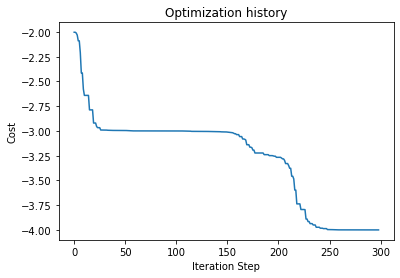

Ideal cost:  -4.0


In [20]:
def qaoa_ideal_cost(params: np.array) -> float:
    """Ideal cost function of the QAOA problem without noise."""
    qaoa_circuit = qaoa_ansatz(graph, params)
    qaoa_obs = qaoa_hamiltonian(graph)
    return executor(qaoa_circuit, qaoa_obs, noise=0)

ideal_opt_cost, ideal_opt_params, traj = minimize_cost(qaoa_ideal_cost, init_params)
print("Ideal cost: ", np.round(ideal_opt_cost, 4))

Since the simulation is exact, we reach the optimal cost associated to (minus) the maximum number of cuts of the graph.

## Using a noisy unmitigated simulator

We assume to have some depolarizing noise. This means that we need to re-define the QAOA cost function using a noisy executor function.

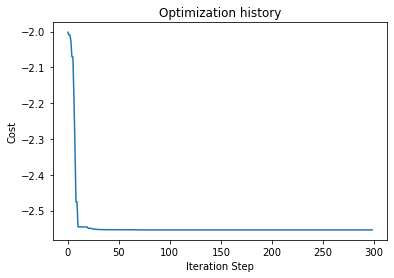

In [21]:
BASE_NOISE = 0.03
def qaoa_noisy_cost(params: np.array) -> float:
    """Noisy cost function of the QAOA problem."""
    qaoa_circuit = qaoa_ansatz(graph, params)
    qaoa_obs = qaoa_hamiltonian(graph)
    return executor(qaoa_circuit, qaoa_obs, noise=BASE_NOISE)

noisy_opt_cost, noisy_opt_params, noisy_traj = minimize_cost(qaoa_noisy_cost, init_params)

Because of noise, the QAOA optimization is not able to converge to the optimal solution. 

Indeed the variational parameters optimized with noise do not minimize the ideal cost.

In [22]:
print("Noisy cost: ", np.round(noisy_opt_cost, 4))
print("Ideal cost evaluated at noisy parameters: ", np.round(qaoa_ideal_cost(noisy_opt_params), 4))
print("Ideal cost: ", np.round(ideal_opt_cost, 4))

Noisy cost:  -2.5539
Ideal cost evaluated at noisy parameters:  -3.0002
Ideal cost:  -4.0


### Using a noisy simulator mitigated with Mitiq

Now let's try to mitigate this noise using Mitiq.

This can be done by simply wrapping the noisy executor into a mitigated executor.

In [23]:
import mitiq
from mitiq.zne import mitigate_executor

# Choose a noise scaling method
scaling_method = mitiq.zne.scaling.fold_global

# Initialize an inference method (i.e. a Mitiq Factory)
inference_factory = mitiq.zne.inference.LinearFactory(scale_factors=[1.0, 3.0])

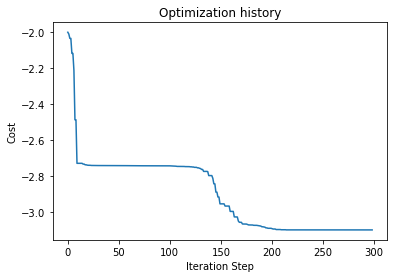

In [24]:
from functools import partial

def qaoa_mitigated_cost(params: np.array) -> float:
    """Cost function of the QAOA problem using error mitigation."""
    qaoa_circuit = qaoa_ansatz(graph, params)
    qaoa_obs = qaoa_hamiltonian(graph)
    noisy_executor = partial(executor, obs=qaoa_obs, noise=BASE_NOISE)
    mitigated_executor = mitigate_executor(noisy_executor, inference_factory, scaling_method)
    return mitigated_executor(qaoa_circuit)

mitig_opt_cost, mitig_opt_params, mitig_traj = minimize_cost(qaoa_mitigated_cost, init_params)

In [25]:
print("Mitigated cost: ", np.round(mitig_opt_cost, 4))
print("Noisy cost evaluated at noisy parameters: ", np.round(noisy_opt_cost, 4))
print("Noisy cost evaluated at mitigated parameters: ",np.round(qaoa_noisy_cost(mitig_opt_params), 4))
print("Ideal cost evaluated at noisy parameters: ", np.round(qaoa_ideal_cost(noisy_opt_params), 4))
print("Ideal cost evaluated at mitigated parameters: ", np.round(qaoa_ideal_cost(mitig_opt_params), 4))
print("Ideal cost: ", np.round(ideal_opt_cost, 4))

Mitigated cost:  -3.0967
Noisy cost evaluated at noisy parameters:  -2.5539
Noisy cost evaluated at mitigated parameters:  -2.7841
Ideal cost evaluated at noisy parameters:  -3.0002
Ideal cost evaluated at mitigated parameters:  -3.9338
Ideal cost:  -4.0


The optimization was clearly enhanced by the application of zero-noise extrapolation. 

### Trying ZNE with different noise scaling methods and different inference methods

With Mitiq, it is very easy to switch between different ZNE methods. For example, to use a different noise scaling method, we can simply import a different function from `mitiq.zne.scaling`:

In [26]:
# Choose a noise scaling method
scaling_method = mitiq.zne.scaling.fold_gates_at_random

# Initialize an inference method (i.e. a Mitiq Factory)
inference_factory = mitiq.zne.inference.LinearFactory(scale_factors=[1.0, 3.0])

The next two cells are exactly equal to those of the previous subsection.

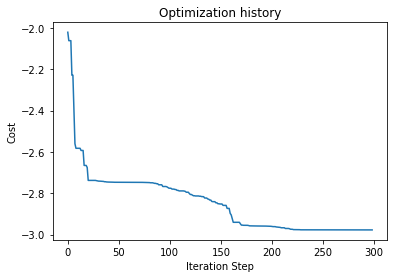

In [27]:
def qaoa_mitigated_cost(params: np.array) -> float:
    """Cost function of the QAOA problem using error mitigation."""
    qaoa_circuit = qaoa_ansatz(graph, params)
    qaoa_obs = qaoa_hamiltonian(graph)
    noisy_executor = partial(executor, obs=qaoa_obs, noise=BASE_NOISE)
    mitigated_executor = mitigate_executor(noisy_executor, inference_factory, scaling_method)
    return mitigated_executor(qaoa_circuit)

mitig_opt_cost, mitig_opt_params, mitig_traj = minimize_cost(qaoa_mitigated_cost, init_params)

In [28]:
print("Mitigated cost: ", np.round(mitig_opt_cost, 4))
print("Noisy cost evaluated at noisy parameters: ", np.round(noisy_opt_cost, 4))
print("Noisy cost evaluated at mitigated parameters: ",np.round(qaoa_noisy_cost(mitig_opt_params), 4))
print("Ideal cost evaluated at noisy parameters: ", np.round(qaoa_ideal_cost(noisy_opt_params), 4))
print("Ideal cost evaluated at mitigated parameters: ", np.round(qaoa_ideal_cost(mitig_opt_params), 4))
print("Ideal cost: ", np.round(ideal_opt_cost, 4))

Mitigated cost:  -2.9777
Noisy cost evaluated at noisy parameters:  -2.5539
Noisy cost evaluated at mitigated parameters:  -2.6837
Ideal cost evaluated at noisy parameters:  -3.0002
Ideal cost evaluated at mitigated parameters:  -3.924
Ideal cost:  -4.0


### How to reproduce this notebook

This notebook was executed on Mitiq master branch, on commit 7d885cd5b58fae5f3dbec0871b198e171883b17d

In [29]:
mitiq.about()


Mitiq: A Python toolkit for implementing error mitigation on quantum computers
Authored by: Mitiq team, 2020 & later (https://github.com/unitaryfund/mitiq)

Mitiq Version:	0.4.0dev

Core Dependencies
-----------------
Cirq Version:	0.9.1
NumPy Version:	1.18.5
SciPy Version:	1.4.1

Optional Dependencies
---------------------
PyQuil Version:	2.18.0
Qiskit Version:	0.12.0

Python Version:	3.7.7
Platform Info:	Linux (x86_64)
